In [22]:
!where python

/bin/bash: line 1: where: command not found


# Load libraries

In [23]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from glob import glob
import os
from copy import deepcopy

import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define helper functions/classes

In [24]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

# def convert_to_feed_model_func(RGB_image):

#     sz0=RGB_image.shape[0]
#     sz1=RGB_image.shape[1]

#     train_imgs=np.zeros((sz0,sz1,2))
#     train_input=np.zeros((sz0,sz1,1))

#     ab=np.zeros((sz0,sz1,2))
#     R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
#     G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
#     B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
#     L, A, B = RGB2LAB2(R1,G1,B1)
#     A = np.reshape(A,(sz0,sz1))
#     B = np.reshape(B,(sz0,sz1))
#     ab[:,:,0] = A
#     ab[:,:,1] = B
#     train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#     train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

#     return (train_input, train_imgs)


In [25]:

####### Metrics #######


def psnr(img1, img2):
    mse = np.mean( (img1.astype("float") - img2.astype("float")) ** 2 )
    # print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)

	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def mae(imageA, imageB, bands):
 	# the 'Mean Squared Error' between the two images is the
 	# sum of the squared difference between the two images;
 	# NOTE: the two images must have the same dimension
 	err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
 	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
 	return err

def rmse(imageA, imageB, bands):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1] * bands)
	err = np.sqrt(err)
	return err

# Define transforms


In [26]:
class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz0=img.shape[0]
        sz1=img.shape[1]

        train_imgs=np.zeros((sz0,sz1,2))
        train_input=np.zeros((sz0,sz1,1))

        ab=np.zeros((sz0,sz1,2))
        R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
        G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
        B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        A = np.reshape(A,(sz0,sz1))
        B = np.reshape(B,(sz0,sz1))
        ab[:,:,0] = A
        ab[:,:,1] = B
        train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
        train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
        return (train_input, train_imgs)

In [27]:
# NOTE: need to crate a transform class to revert from model to RGB, so the oposite from the class convert_RGB_to_feed_model
class convert_from_LAB_to_RGB(torch.nn.Module):
    def forward(self, img_raw):
        image, _ = img_raw
        print(image.shape)
        # sz0 = image.shape[0]
        # sz1 = image.shape[1]
        # sz2 = image.shape[2]
        # LAB_img = np.reshape(LAB_img,(sz0*sz1,bands))
        # Ar = LAB_img[:,0:1]
        # Br = LAB_img[:,1:2]

        # Rr, Gr, Br = LAB22RGB(L,Ar,Br)
        # Rr = np.reshape(Rr,(sz0,sz1))
        # Gr = np.reshape(Gr,(sz0,sz1))
        # Br = np.reshape(Br,(sz0,sz1))
        # predicted255=np.uint8(np.zeros((sz0,sz1,3)))
        # predicted255[:,:,0] = Rr
        # predicted255[:,:,1] = Gr
        # predicted255[:,:,2] = Br
        # return (predicted255)

In [28]:
img_new_dim = 512

train_transforms = transforms.Compose(
    [
        # transforms.Resize(size=(img_new_dim, img_new_dim)),
        convert_RGB_to_feed_model()
        # transforms.Lambda(convert_to_feed_model),
        # v2.RandomHorizontalFlip(p=1),
        # v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    ]
)

# Download the raw data

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.

NOTE: the following are links stored in a private server, jet publically available

In [29]:
# raw_data_csv_file_link = "https://perritos.myasustor.com:3853/portal/apis/fileExplorer/download.cgi?act=download&link=EKxhA76k9&link_session_id=cDXOk9eeE9Es2a1JU1IOvA00&total=1&browser=firefox&mod_cntype=0&path=%2FRuben%2Fdatasets%2Ffetched_raw_imgs_via_api&file=metadata.csv"
raw_data_csv_file_link = "https://perritos.myasustor.com:1985/metadata.csv"
# only working locally
# raw_data_csv_file_link =
# "/Volumes/Ruben/datasets/fetched_raw_imgs_via_api/metadata.csv"

metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df

,img_id,img_name,latitude,longitude,zoom_level,class,link
0,0,3857_17_68545_45993,47.201780,8.264822,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
1,1,3857_16_34290_23041,47.032835,8.360899,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
2,2,3857_16_34497_22906,47.536282,9.500052,16,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3,3,3857_17_67996_46176,46.860006,6.759327,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
4,4,3857_17_68797_46090,47.021068,8.959244,17,61,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
...,...,...,...,...,...,...,...
3595,3595,3857_17_68680_46248,46.723525,8.635565,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3596,3596,3857_16_34412_23109,46.778972,9.030993,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3597,3597,3857_17_68885_46306,46.613634,9.199782,17,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....
3598,3598,3857_16_34489_23157,46.598598,9.455155,16,66,https://wmts0.geo.admin.ch/1.0.0/ch.swisstopo....


In [30]:
metadata_raw_df["class"].iloc[0]

61

In [31]:
metadata_raw_df.shape

(3600, 7)

# Create Train, Valid and Test datasets

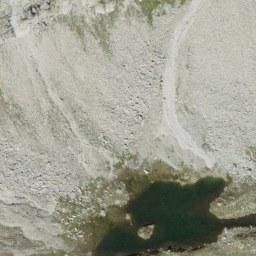

In [32]:
# This is an example how to retrieve a sample image
url = "https://perritos.myasustor.com:1985/data/img_id_10.jpg"
# url = "https://192.168.1.144:1985/data/img_id_0.jpg"
response = requests.get(url)
img_test = Image.open(BytesIO(response.content))
img_test

In [33]:
transformed_img = train_transforms(img_test)
transformed_img

(array([[[0.64623137],
         [0.72074118],
         [0.74427059],
         ...,
         [0.68269804],
         [0.71407059],
         [0.77681569]],
 
        [[0.61093725],
         [0.70897647],
         [0.76387843],
         ...,
         [0.69838431],
         [0.70622745],
         [0.73367843]],
 
        [[0.68293333],
         [0.72607059],
         [0.70646275],
         ...,
         [0.72191373],
         [0.71407059],
         [0.69054118]],
 
        ...,
 
        [[0.56183922],
         [0.54105882],
         [0.5265451 ],
         ...,
         [0.56870196],
         [0.59615294],
         [0.53732941]],
 
        [[0.53628627],
         [0.52172941],
         [0.51275686],
         ...,
         [0.49508627],
         [0.49900784],
         [0.48332157]],
 
        [[0.52844314],
         [0.51275686],
         [0.51667843],
         ...,
         [0.53038039],
         [0.53038039],
         [0.54606667]]]),
 array([[[-0.01377577,  0.0299388 ],
         [-0.01377

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 75, 15 and 10 % respectively

In [34]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 2700.
the size fo the validation dataset is: 540.
the size fo the test dataset is: 360.


# Create a Dataset class

In [35]:
# the idea was borrowed from here: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

class Swisstopodataset(Dataset):
    def __init__(self, img_indx, metadata_file, transform = False):
        self.img_indx = img_indx
        self.transform = transform
        self.metadata_file = metadata_file

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        response = requests.get(f"https://perritos.myasustor.com:1985/data/img_id_{self.img_indx[idx]}.jpg")
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing
        label = self.metadata_file["class"].iloc[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [36]:
train_dataset = Swisstopodataset(x_train, metadata_file=metadata_raw_df, transform=train_transforms)
valid_dataset= Swisstopodataset(x_val, metadata_file=metadata_raw_df, transform=None) # no transform applied?
test_dataset= Swisstopodataset(x_test, metadata_file=metadata_raw_df, transform=train_transforms)
example_indx = 49

print(f"The shape of tensor for {example_indx +1 }th image in the train dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
print(f"\n\nThe shape of tensor for {example_indx +1 }th image in the validate dataset of: \nchannel L is:{train_dataset[example_indx][0][0].shape}\nchannel AB is:{train_dataset[example_indx][0][1].shape}\nlabel: {train_dataset[example_indx][1]}")
# print(f"The shape of tensor for 50th image in train dataset of channel L is :{train_dataset[49][0].shape}\nand of channel AB is :{train_dataset[49][1].shape}")


The shape of tensor for 50th image in the train dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


The shape of tensor for 50th image in the validate dataset of: 
channel L is:(256, 256, 1)
channel AB is:(256, 256, 2)
label: 61


In [37]:
valid_dataset[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>, 61)

# Visualize the datasets (images)

In [38]:
def visualize_dataset(dataset, samples = 10, cols = 5, random_img = False):
    dataset = deepcopy(dataset)
    # revert transforms if exixting
    # dataset.transform = transforms.Compose([t for t in dataset.transform if not isinstance(t, convert_RGB_to_feed_model)])
    dataset.transform = transforms.Compose([t for t in test_dataset.transform.transforms if not t.__class__.__name__ == "convert_RGB_to_feed_model"])
    # if "convert_RGB_to_feed_model" in test_dataset.transform.transforms:
    #     dataset.transform = transforms.Compose()

    rows = samples // cols

    figure, ax = plt.subplots(nrows= rows, ncols = cols, figsize = (12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(dataset))
        image, label = dataset[idx][0], dataset[idx][1]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Img label: {label}")
    plt.tight_layout(pad=1)
    plt.show()

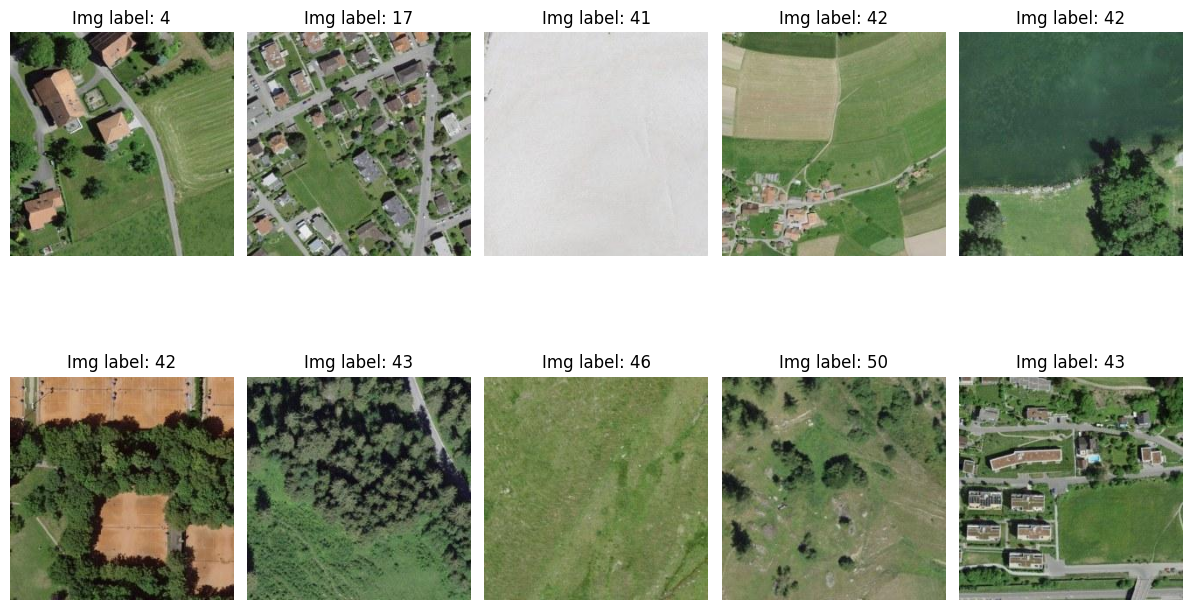

In [39]:
visualize_dataset(test_dataset, random_img= True)

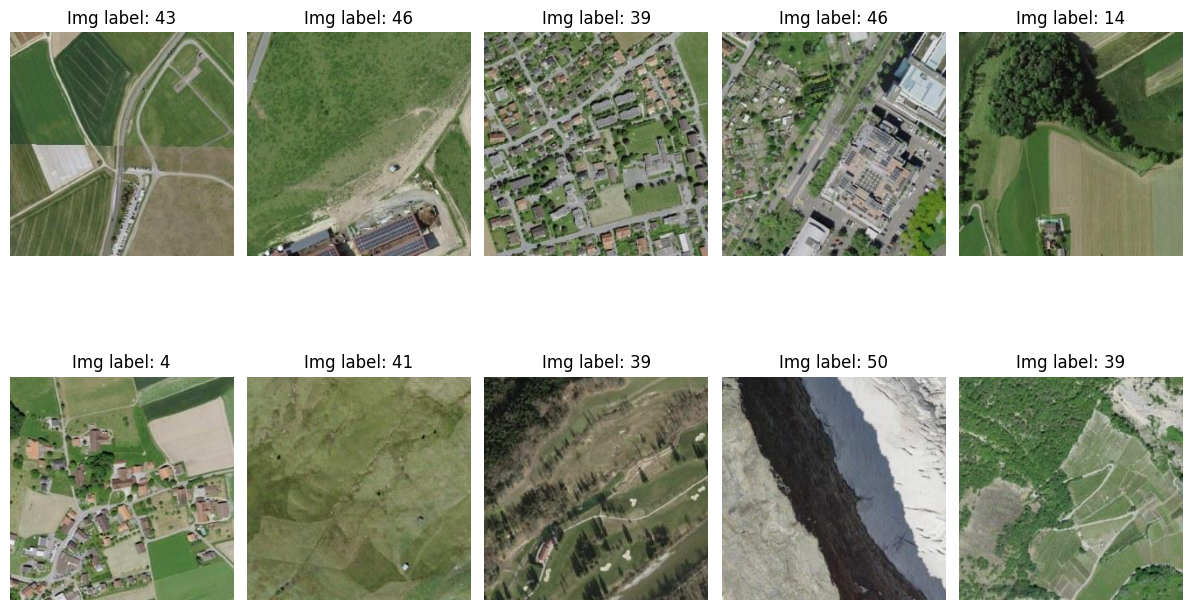

In [40]:
visualize_dataset(valid_dataset, random_img= True)

# Creating a DataLoader

In [41]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [ ]:
#batch of image tensor channel L
print(next(iter(train_loader))[0][0].shape)
#batch of image tensor channel AB
print(next(iter(train_loader))[0][1].shape)

torch.Size([64, 256, 256, 1])
